In [46]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from matplotlib import pyplot as plt
from tensorflow import keras
import numpy as np
import xgboost
import json

In [47]:
def knn(x_train, y_train, x_test, parameters = {}):
    classifier = KNeighborsClassifier(**parameters)
    fit = classifier.fit(x_train, y_train)
    probabilities = fit.predict_proba(x_test)[:,1]
    return probabilities

def logistic_regression(x_train, y_train, x_test, parameters = {}):
    classifier = LogisticRegression(solver = 'liblinear', penalty='l1', **parameters)
    fit = classifier.fit(x_train, y_train)
    probabilities = fit.predict_proba(x_test)[:,1]
    return probabilities

def support_vector_machine(x_train, y_train, x_test, parameters = {}):
    classifier = SVC(probability = True, gamma='scale', cache_size=1000, **parameters)
    fit = classifier.fit(x_train, y_train)
    probabilities = fit.predict_proba(x_test)[:,1]
    return probabilities

def boosted_forest(x_train, y_train, x_test, parameters = {}):
    classifer = xgboost.XGBClassifier(**parameters)
    fit = classifer.fit(x_train, y_train)
    probabilities = fit.predict_proba(x_test)[:,1]
    return probabilities

def neural_network(x_train, y_train, x_test, parameters = {}):
    model = keras.Sequential()
    model.add(keras.layers.Dense(300, activation="relu"))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(150, activation="relu"))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(50, activation="relu"))
    model.add(keras.layers.Dense(1, activation="sigmoid"))
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics = ['accuracy'])
    model.fit(x_train, y_train, verbose = 0, epochs = 10)
    return model.predict(x_test).reshape((-1))

def plot(x, y, method, name, parameters = {}):
    fprs = []
    tprs = []
    aucs = []

    folds = 5
    i = 1
    plt.figure(dpi = 150, facecolor = 'white')
    for train, test in KFold(n_splits = folds).split(x):
        print (f'Starting Fold {i}')
        x_train = x[train]
        y_train = y[train]
        x_test = x[test]
        y_test = y[test]

        y_scores = method(x_train, y_train, x_test, parameters)
        fpr, tpr, thresholds = roc_curve(y_test, y_scores)
        
        auc = roc_auc_score(y_test, y_scores)

        fprs.append(np.linspace(0, 1, 101))
        tprs.append(np.interp(np.linspace(0, 1, 101), fpr, tpr))
        aucs.append(auc)

        plt.plot(fpr, tpr, linewidth = 1, alpha = 0.3, label = f"ROC Fold {i} (AUC = {auc:.2f})")
        i += 1
        
    mean_fpr = np.mean(fprs, axis = 0)
    std_fpr = np.std(fprs, axis = 0)
    mean_tpr = np.mean(tprs, axis = 0)
    std_tpr = np.std(tprs, axis = 0)
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)

    lower_fpr = mean_fpr - std_fpr
    upper_fpr = mean_fpr + std_fpr
    lower_tpr = mean_tpr - std_tpr
    upper_tpr = mean_tpr + std_tpr

    lower_tpr = np.interp(mean_fpr, upper_fpr, lower_tpr) 
    upper_tpr = np.interp(mean_fpr, lower_fpr, upper_tpr) 

    plt.fill_between(mean_fpr, lower_tpr, upper_tpr, color = 'grey', alpha = 0.2, label = '$\pm$ 1 std. dev.')
    plt.plot(mean_fpr, mean_tpr, color = 'C0', label = 'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), linewidth = 2, alpha = .8)
    plt.plot([0, 1], [0, 1], linestyle = '--', color = 'black', alpha = 0.8)
    plt.legend(bbox_to_anchor = (1.05, 1))
    plt.title(f'{folds} Fold ROC with {name}')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    

In [ ]:
with open('/active/myler_p/People/Sur/J-IP/LtaP/ivan-pacbio/data.json') as infile:
    contents = json.load(infile)
    data = np.array(contents['vectors'])
    labels = np.array(contents['labels'])

In [53]:
with open('/active/myler_p/People/Sur/J-IP/LtaP/ivan-pacbio/chip_only.json') as infile:
    contents = json.load(infile)
    data = np.array(contents['vectors'])
    labels = np.array(contents['labels'])

In [ ]:
with open('/active/myler_p/People/Sur/J-IP/LtaP/ivan-pacbio/chip_ipd_only.json') as infile:
    contents = json.load(infile)
    data = np.array(contents['vectors'])
    labels = np.array(contents['labels'])

In [54]:
x = data
y = labels

Starting Fold 1
Starting Fold 2
Starting Fold 3
Starting Fold 4
Starting Fold 5


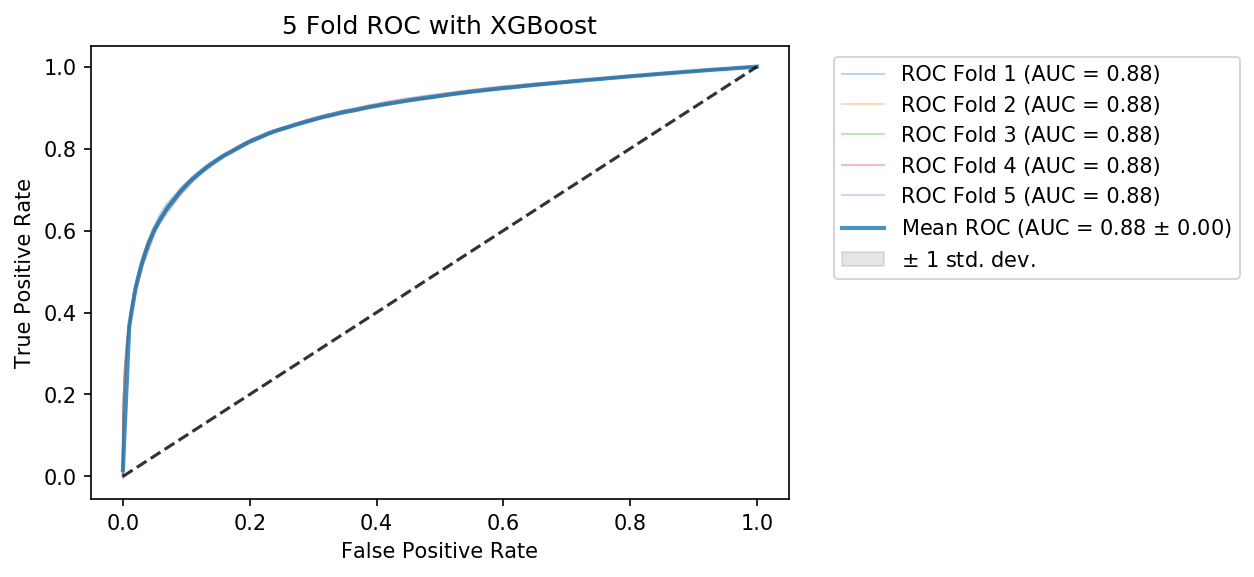

In [57]:
# plot(x, y, logistic_regression, 'Logistic Regression')
plot(x, y, boosted_forest, 'XGBoost')
# plot(x, y , neural_network, 'Neural Network')

In [55]:
classifer = xgboost.XGBClassifier()
fit = classifer.fit(x, y)

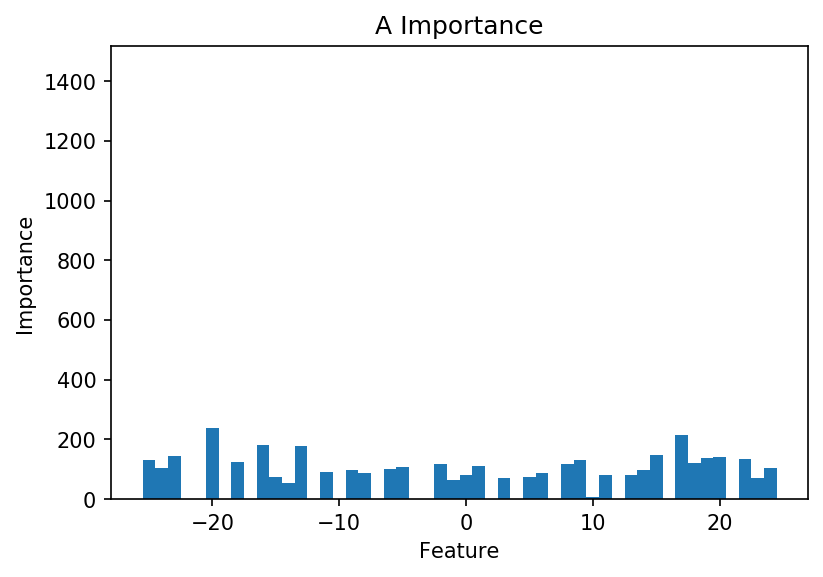

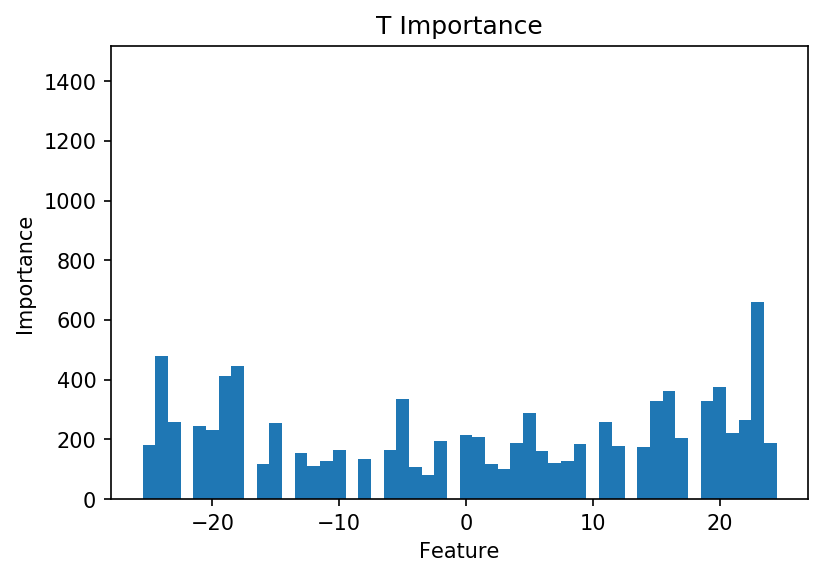

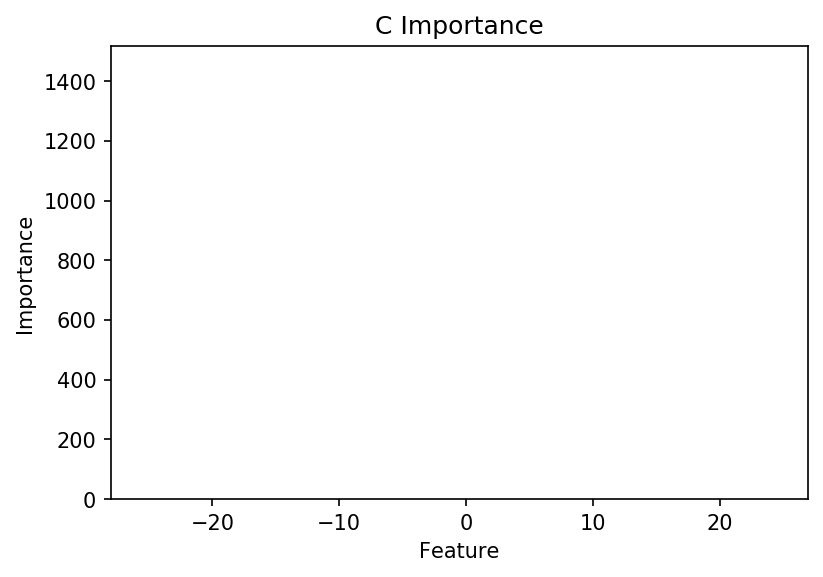

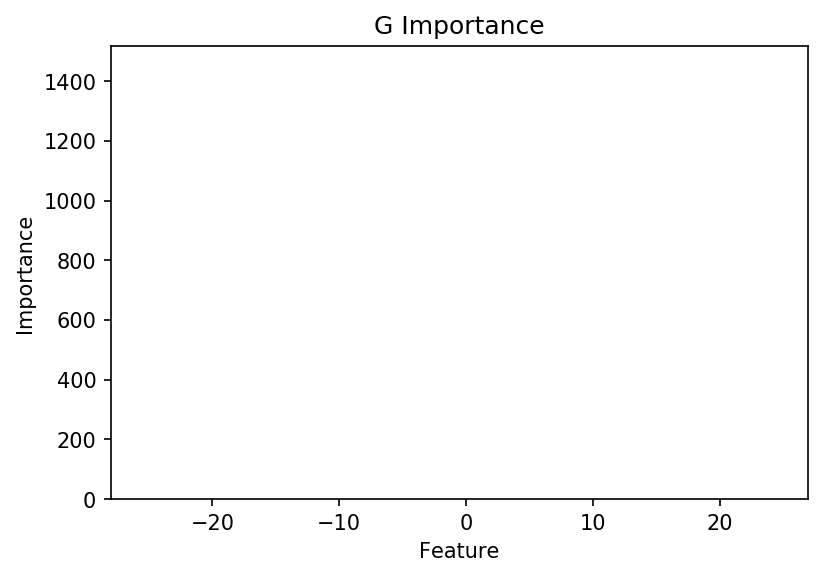

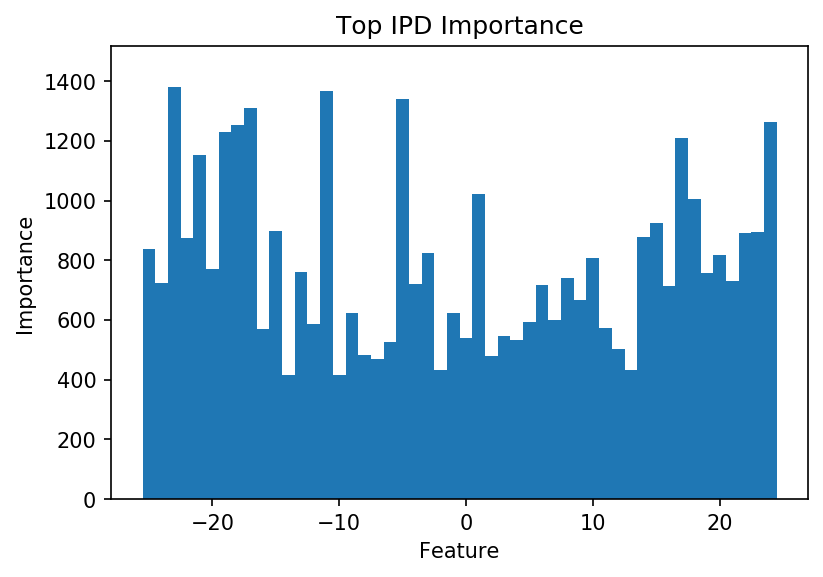

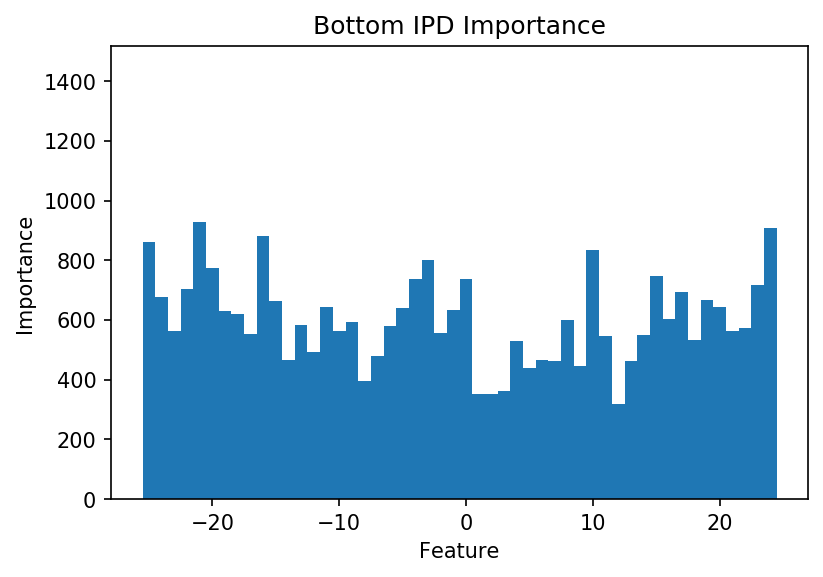

In [56]:
scores = classifer.get_booster().get_score(importance_type = 'gain')
weights = np.zeros(len(x[0]))
for i in range(len(weights)):
    index = f'f{i}'
    if index in scores.keys():
        weights[i] = scores[index]

start = 0
stop = 50
ylim = [0, max(weights)*1.1]
for i in ['A', 'T', 'C', 'G', 'Top IPD', 'Bottom IPD']:
    plt.figure(figsize = (6,4), dpi = 150)
    plt.bar(range(-25, 25), weights[start:stop], width = 1)
    plt.ylabel('Importance')
    plt.xlabel('Feature')
    plt.title(f'{i} Importance')
    plt.ylim(ylim)
    plt.show()

    start += 50
    stop += 50